<h1>Importing Liabraries and Dataset</h1>

In [34]:
'''note : while running this cell you may face a error as cannot import name 'Sequence' from 'keras.utils' for that you 
just need to click on the generator.py file shown in the error and then a popup showing generator file will come. In the 
18 th line you just need to replace 'keras.utils import Sequence' with 'tensorflow.keras.utils import Sequence' '''

!pip install keras-video-generators
!pip install mtcnn

from google.colab import drive
import os
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import os
import glob
import keras
from tensorflow.keras.utils import Sequence
from keras_video import VideoFrameGenerator
from keras.layers import *
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
import pandas as pd
import json
import numpy as np
import gc
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

     |████████████████████████████████| 2.3 MB 5.4 MB/s 


<h3>We will now mount our drive on the colab file so as to access the drive folders</h3>

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


<h1> Data Preprocessing and Custom Generator</h1>


<h4>This dataset has videos which have been already preprocessed and contains only face cropped images</h4>

In [6]:
# this function will get the classes names according to the directories and the passed the data for augmentation and generating batches
# we used custom model since we need data in shape of (number of frames, (size of image/frame),3) to train our model

#we will pass only 10 frames to our model since we don't have resources to train our model on 100 frames

classes = ['Fake','Real']
classes.sort()

SIZE = (112,112)
CHANNELS = 3
NBFRAME = 10
BS = 4
# pattern to get videos and classes
glob_pattern='/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/{classname}/*.mp4'

In [7]:
# we will only rescale our images and won't use any data augmentation technique
# train files consists of total 3775 files and validation files consists of 665 files

data_aug = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255
    )
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.15, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class Fake, validation count: 319, train count: 1812
class Real, validation count: 346, train count: 1963
Total data: 2 classes for 3775 files for train


In [8]:
valid = train.get_validation_generator()

Total data: 2 classes for 665 files for validation


<h1>Building Model</h1>

In [17]:
# we have made our custom model and will use resnet50 architecture for prediction by fine tuning it

from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D

def build_convnet(shape=(112,112, 3)):
    
    model = keras.Sequential()
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=shape)

    # due to resource exhaustation we are not doing fine tuning
    
    for layer in resnet.layers:
      layer.trainable = False

    model.add(resnet)
    model.add(Dropout(0.25))
    model.add(GlobalMaxPool2D())
    
    return model

In [18]:
# this function defined the time distributed layer which is used for image sequencing or when feeding multiple images to the model

from keras.layers import TimeDistributed, LSTM, Dense, Dropout,Flatten
def action_model(shape=(100, 112,112, 3),nbout=1):
    
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    
    model.add(TimeDistributed(convnet, input_shape=shape))
    
    model.add(LSTM(100))
    model.add(Dropout(.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(2, activation='softmax'))
    return model

In [19]:
# we will use binary crossentopy as our loss and adam optimizer

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (10, 112, 112, 3)

model = action_model(INSHAPE, 2)
optimizer = tf.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 2048)          23587712  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               859600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 24,457,614
Trainable params: 869,902
Non-trainable params: 23,587,712
____________________________________

<h1>Training the Model</h1>

In [23]:
# we will save our weights to this folder
try:
  os.mkdir('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/chkp/')

except:
  print('Directory Exits')
  
for files in os.listdir('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/chkp/'):
    os.remove('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/chkp'+files)

Directory Exits


In [25]:
EPOCHS=2
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside

callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        '/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/chkp/weights.{epoch:02d}-{accuracy:.2f}.hdf5',
        verbose=1),
]
history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=4
)

Epoch 1/2
943/943 [==============================] - 1400s 1s/step - loss: 0.7133 - accuracy: 0.4963 - val_loss: 0.6923 - val_accuracy: 0.5211

Epoch 00001: saving model to /content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/chkp/weights.01-0.50.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/2
943/943 [==============================] - 105s 112ms/step - loss: 0.6969 - accuracy: 0.5077 - val_loss: 0.6923 - val_accuracy: 0.5211

Epoch 00002: saving model to /content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/chkp/weights.02-0.51.hdf5


In [26]:
#save weight so we can use it later

try:
  os.mkdir('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(upgradation)')

except:
  print('Directory already exists')
  
model.save('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(upgradation)/weights')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(upgradation)/weights/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(upgradation)/weights/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [27]:
#this custom graph can plot graph for loss as well for accuracy
def plot_graph(history,string):
    
    plt.plot(history.history[string],label='training '+string)
    plt.plot(history.history['val_'+string],label='validation '+string)
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.grid()
    plt.title(string+' vs epochs')
    plt.savefig('./'+string+'.png')
    plt.show()

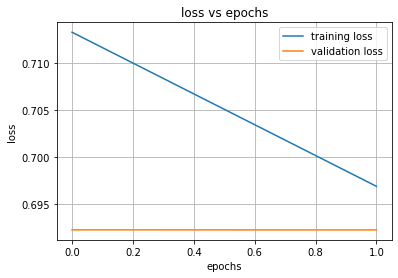

In [28]:
# plot loss graph
plot_graph(history,'loss')

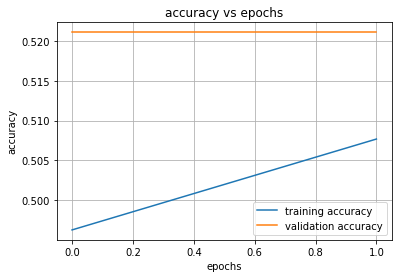

In [29]:
# plot accuracy graph
plot_graph(history,'accuracy')

<h1>Prediction</h1>

In [30]:
#loading the saved model

model = keras.models.load_model('/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/weights(upgradation)/weights')

In [36]:
# crop_frames cropped the faces from the video and then stacked it together

def crop_frames(image,img_stack,k,size):
    
    faces = detector.detect_faces(image)
    p= 60
    
    if(len(faces)>0):
        for face in faces:

            x, y, width, height = face['box']
            x = x - min(x,60)
            x1 = x+width+ min(image.shape[1]-x-width,60)
            y = y - min(y,60)
            y1 = y+height+ min(image.shape[0]-y-height,60)
            crop = np.array(image[y:y1,x:x1])
            crop = cv.cvtColor(crop,cv.COLOR_BGR2RGB)
            crop = cv.resize(crop,size)
            k = k+1
            
            if k>=frames:
                break

            img_stack.append(crop)

    return k,img_stack

In [50]:
# model which is used to predict video , you just need to set the path

detector = MTCNN()

size = (112,112)
frames = 11
iter = 100

frame = np.arange(10,iter)

path = '/content/drive/MyDrive/deepfake_detection/DeepFake_Detection/Train (Upgradation)/Real/abbgqbrdiz.mp4' # add the path to the video you want to predict for

cnt = 0
k = 0
cap = cv.VideoCapture(path)

img_stack = []
    
while(cnt<iter):
  _,image = cap.read()
          
  if cnt in frame:
    k,img_stack = crop_frames(image,img_stack,k,size)
          
  if k == frames:
    break

  cnt= cnt+1
    
img_stack = np.array(img_stack).reshape(-1,10,112,112,3)
        
output = np.argmax(model.predict(img_stack))

if output==0:
  print('Video is forged')

else:
  print('Video is real')


Video is real
